In [64]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Getting images of same view from different camera positions

In [65]:
img1 = cv.imread('9.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('10.png', cv.IMREAD_GRAYSCALE)

Plotting both images side by side and plotting horizontal lines on both images to view the difference in the images

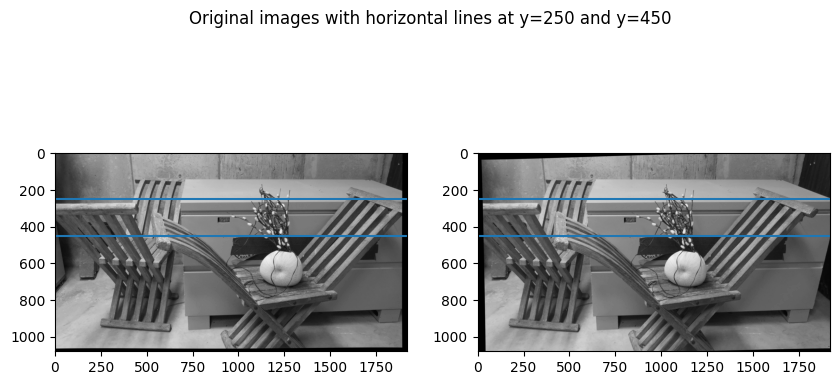

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
axes[0].axhline(250)
axes[0].axhline(450)
axes[1].axhline(250)
axes[1].axhline(450)
plt.suptitle("Original images with horizontal lines at y=250 and y=450")
plt.show()

Finding SIFT features in both images

In [67]:
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

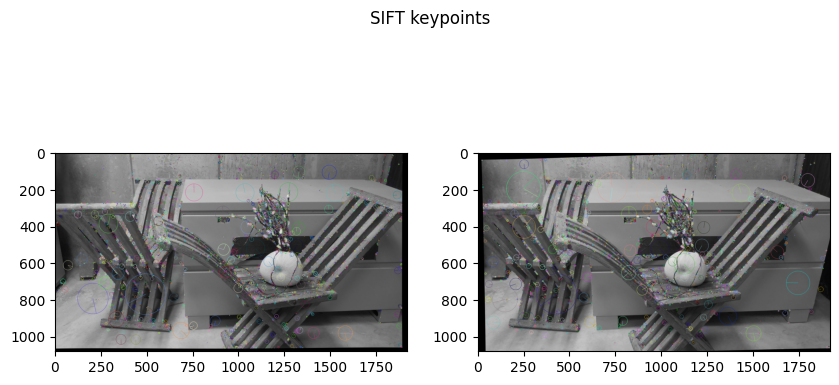

In [68]:
imgSiftPoints1 = cv.drawKeypoints(
    img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgSiftPoints2 = cv.drawKeypoints(
    img2, kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(imgSiftPoints1)
axes[1].imshow(imgSiftPoints2)
plt.suptitle("SIFT keypoints")
plt.show()

Matching the features in both images using Brute Force Matcher

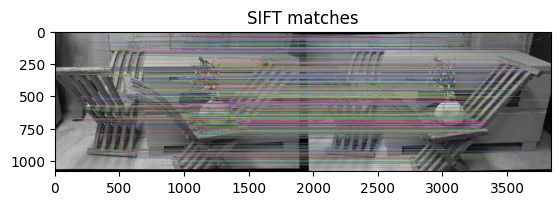

In [69]:
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

keptMatches = []
for i in range(len(matches)):
    keptMatches.append([0, 0])

good_matches = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.70*n.distance:
        keptMatches[i] = [1, 0]
        good_matches.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

imgMatch = cv.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, matchesMask=keptMatches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(imgMatch)
plt.title("SIFT matches")
plt.show()


Finding the Homography matrix using RANSAC and keeping only the inliers

In [70]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

Camera Intrensic Parameters

In [71]:
K1 = np.array([[1.34122312e+03, 0.00000000e+00, 8.07934366e+02],
 [0.00000000e+00, 1.34010510e+03, 5.76372985e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype=np.float64)

dist1 = np.array([[ 2.61866096e-01, -1.97855947e+00, -1.10656452e-03,  1.36832864e-03, 4.80735987e+00]], dtype=np.float64)

K2 = np.array([[1.34122312e+03, 0.00000000e+00, 8.07934366e+02],  
    [0.00000000e+00, 1.34010510e+03, 5.76372985e+02],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype=np.float64)

dist2 = np.array([[ 2.61866096e-01, -1.97855947e+00, -1.10656452e-03,  1.36832864e-03, 4.80735987e+00]], dtype=np.float64)

Checking triangulation to check if R,t are correct

In [72]:
def check_triangulation(R, t, pts1, pts2, K):
    inv_K = np.linalg.inv(K)
    pts1_norm = inv_K @ np.vstack((pts1.T, np.ones((1, pts1.shape[0]))))
    pts1_norm /= pts1_norm[2, :]
    pts2_norm = inv_K @ np.vstack((pts2.T, np.ones((1, pts2.shape[0]))))
    pts2_norm /= pts2_norm[2, :]
    
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = np.hstack((R, t.reshape(3, 1)))
    P1_K = K @ P1
    P2_K = K @ P2
    
    pts4d_hom = cv.triangulatePoints(P1_K, P2_K, pts1_norm[:2, :], pts2_norm[:2, :])
    pts4d = pts4d_hom / pts4d_hom[3, :]
    pts3d = pts4d[:3, :].T
    
    z1 = pts3d @ R[:, 2] + t[2]
    z2 = pts3d @ np.array([0, 0, -1]) - t[2]
    in_front_of_both = (z1 > 0) & (z2 > 0)
    
    return in_front_of_both.all()

Getting Essential matrix and R,t from it

In [73]:
from numpy.linalg import svd

def extract_camera_poses(E, pts1, pts2, K1):
    U, S, Vt = svd(E)
    
    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1
    
    R1 = U @ [[0, 1, 0], [-1, 0, 0], [0, 0, 1]] @ Vt
    R2 = U @ [[0, -1, 0], [1, 0, 0], [0, 0, 1]] @ Vt
    
    t1 = U[:, 2]
    t2 = -U[:, 2]
    
    if check_triangulation(R1, t1, pts1, pts2, K1):
        return R1, t1
    elif check_triangulation(R1, t2, pts1, pts2, K1):
        return R1, t2
    elif check_triangulation(R2, t1, pts1, pts2, K1):
        return R2, t1
    elif check_triangulation(R2, t2, pts1, pts2, K1):
        return R2, t2
    
# R, t = extract_camera_poses(fundamental_matrix, pts1, pts2, K1)

Getting Homography matrices using fundamental matrix

In [74]:
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1))

Getting rectified images

In [75]:
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))

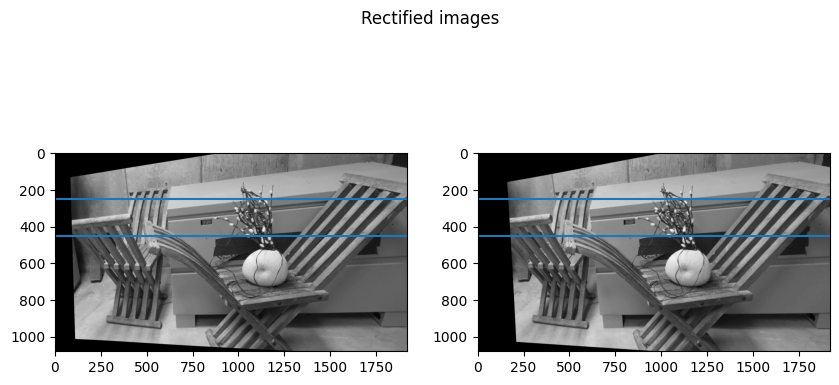

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[0].axhline(450)
axes[1].axhline(250)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.show()

Getting disparity Map

In [77]:
block_size = 11
min_disp = -128
max_disp = 128
num_disp = max_disp - min_disp
uniquenessRatio = 10
speckleWindowSize = 200
speckleRange = 2
disp12MaxDiff = 1

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)

disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)

disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)

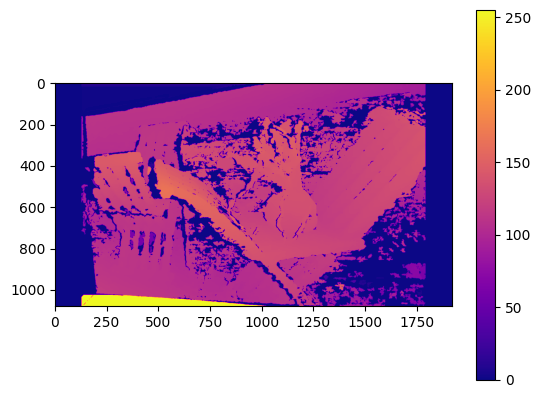

In [78]:
plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
# plt.savefig('disparity_SGBM/1.png',)
plt.show()


# Using a DL based approach to get depth map

In [79]:
import torch

In [80]:
imgDL = cv.imread('9.png')
model_used = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS", model_used)
midas.eval()

Using cache found in C:\Users\HP/.cache\torch\hub\intel-isl_MiDaS_master


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (d

In [81]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform
imgDL = cv.cvtColor(imgDL, cv.COLOR_BGR2RGB)
input_batch = transform(imgDL)

Using cache found in C:\Users\HP/.cache\torch\hub\intel-isl_MiDaS_master


In [82]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=imgDL.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.numpy()

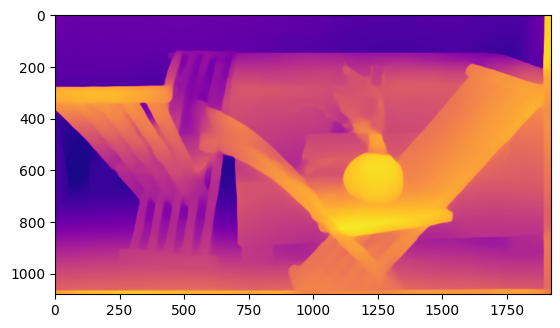

In [83]:
plt.imshow(output, cmap='plasma')
plt.savefig('disparity_SGBM/17DL.png')